# Zipline and Pyfolio test

In [1]:
%load_ext watermark

In [2]:
%load_ext zipline

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import quandl
quandl.ApiConfig.api_key = 'GF19udXJ7Gq1jWNWFa-5'
from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities
from zipline import run_algorithm

# import helper functions 
#import qf_helper_functions as qf

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data register

In [23]:

start_session = pd.Timestamp('2017-01-03', tz='utc')
end_session = pd.Timestamp('2019-06-28', tz='utc')

# register the bundle 
register(
    'apple-prices-2017-2019', # name we select for the bundle
    csvdir_equities(
        ['daily'], # name of the directory as specified above (named after data frequency)
        '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/codes/experiment/aapl.csv', # path to directory containing the data
    ),
    calendar_name='NYSE',  # US equities
    start_session=start_session,
    end_session=end_session
)


/Users/cheng/opt/anaconda3/envs/portfolio/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Overwriting bundle with name 'apple-prices-2017-2019'
  del sys.path[0]


<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x7fd839736990>>

In [5]:
!zipline bundles

apple-prices-2017-2019 2022-01-27 20:07:58.248301
apple-prices-2017-2019 2022-01-27 20:06:59.138794
csvdir <no ingestions>
quandl 2022-01-27 19:15:47.131019
quandl 2022-01-27 19:15:31.184377
quandl 2022-01-27 19:12:02.064419
quantopian-quandl <no ingestions>


In [10]:
!zipline ingest -b apple-prices-2017-2019


[2022-01-27 22:30:45.068661] INFO: zipline.data.bundles.core: Ingesting apple-prices-2017-2019.
Loading custom pricing data:   [------------------------------------]    0% | aapl: sid 0
Loading custom pricing data:   [####################################]  100%
Merging daily equity files:  [####################################]   


## Backtesting

In [25]:
# imports
from zipline.api import order, symbol, record

# parameters
selected_stock = 'AAPL'
n_stocks_to_buy = 10

def initialize(context):
    context.has_ordered = False  

def handle_data(context, data):
    # record price for further inspection
    record(price=data.current(symbol(selected_stock), 'price'))
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order(symbol(selected_stock), n_stocks_to_buy)
        # setting up a flag for holding a position
        context.has_ordered = True

result = run_algorithm(
    start=pd.Timestamp("2018-2-1", tz="UTC"),
    end=pd.Timestamp("2018-12-31", tz="UTC"),
    initialize=initialize,
    capital_base=10000000,
    handle_data=handle_data,
    #before_trading_start=before_trading_start,
    bundle="apple-prices-2017-2019",
    data_frequency='daily'
)

In [26]:
result

,period_open,period_close,positions,long_exposure,short_value,starting_exposure,ending_exposure,long_value,returns,starting_value,...,algorithm_period_return,trading_days,benchmark_period_return,benchmark_volatility,sortino,alpha,beta,algo_volatility,treasury_period_return,period_label
2018-02-01 21:00:00+00:00,2018-02-01 14:31:00+00:00,2018-02-01 21:00:00+00:00,[],0.00,0.0,0.00,0.00,0.00,0.000000e+00,0.00,...,0.000000e+00,1,0.0,NaN,NaN,None,None,NaN,0.0,2018-02
2018-02-02 21:00:00+00:00,2018-02-02 14:31:00+00:00,2018-02-02 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",401.25,0.0,0.00,401.25,401.25,-2.106250e-08,0.00,...,-2.106250e-08,2,0.0,0.0,-11.224972,None,None,2.364260e-07,0.0,2018-02
2018-02-05 21:00:00+00:00,2018-02-05 14:31:00+00:00,2018-02-05 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",391.23,0.0,401.25,391.23,391.23,-1.002000e-06,401.25,...,-1.023063e-06,3,0.0,0.0,-9.355740,None,None,9.088499e-06,0.0,2018-02
2018-02-06 21:00:00+00:00,2018-02-06 14:31:00+00:00,2018-02-06 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",407.57,0.0,391.23,407.57,407.57,1.634002e-06,391.23,...,6.109375e-07,4,0.0,0.0,4.838431,None,None,1.734394e-05,0.0,2018-02
2018-02-07 21:00:00+00:00,2018-02-07 14:31:00+00:00,2018-02-07 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",398.85,0.0,407.57,398.85,398.85,-8.719995e-07,407.57,...,-2.610625e-07,5,0.0,0.0,-1.395098,None,None,1.668931e-05,0.0,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24 18:00:00+00:00,2018-12-24 14:31:00+00:00,2018-12-24 18:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",367.08,0.0,376.82,367.08,367.08,-9.740024e-07,376.82,...,-3.438062e-06,226,0.0,0.0,-0.375471,None,None,1.361406e-05,0.0,2018-12
2018-12-26 21:00:00+00:00,2018-12-26 14:31:00+00:00,2018-12-26 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",392.92,0.0,367.08,392.92,392.92,2.584009e-06,367.08,...,-8.540625e-07,227,0.0,0.0,-0.093059,None,None,1.385722e-05,0.0,2018-12
2018-12-27 21:00:00+00:00,2018-12-27 14:31:00+00:00,2018-12-27 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",390.37,0.0,392.92,390.37,390.37,-2.550002e-07,392.92,...,-1.109062e-06,228,0.0,0.0,-0.120540,None,None,1.382919e-05,0.0,2018-12
2018-12-28 21:00:00+00:00,2018-12-28 14:31:00+00:00,2018-12-28 21:00:00+00:00,"[{'sid': Equity(0 [AAPL]), 'amount': 10, 'cost...",390.57,0.0,390.37,390.57,390.57,2.000002e-08,390.37,...,-1.089062e-06,229,0.0,0.0,-0.118107,None,None,1.379885e-05,0.0,2018-12


Text(0, 0.5, 'Sharpe ratio')

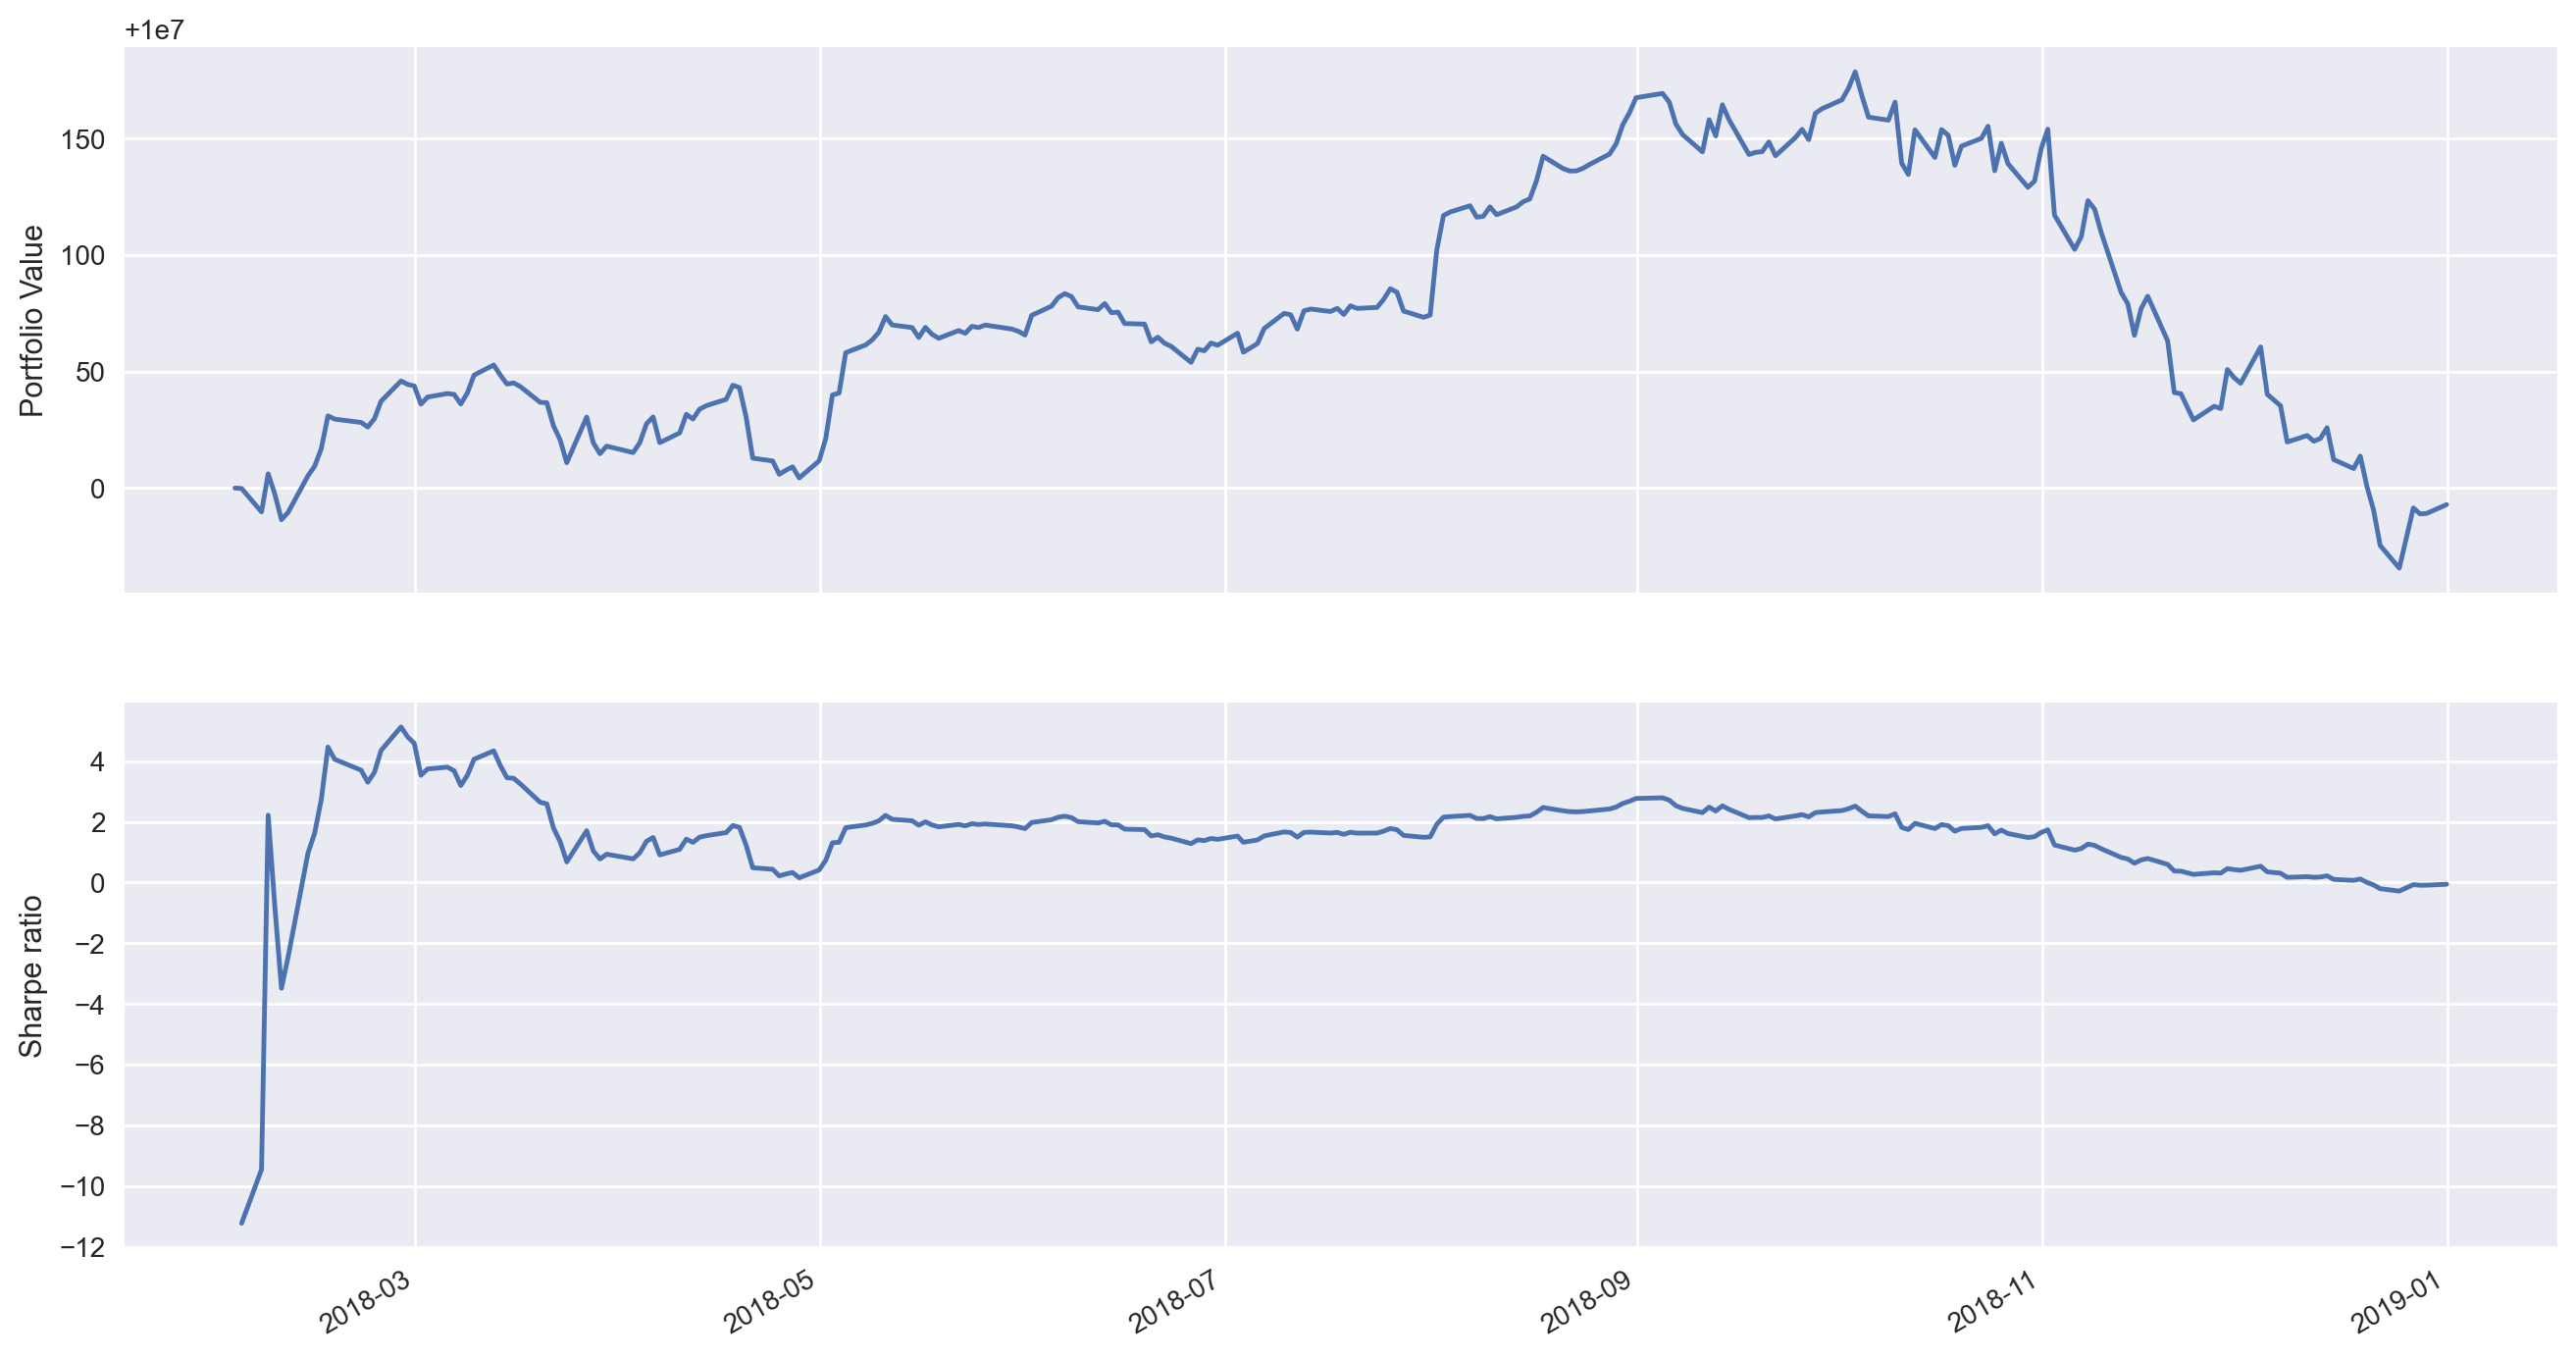

In [27]:
ax1 = plt.subplot(211)
result.portfolio_value.plot(ax=ax1)
ax1.set_ylabel('Portfolio Value')
ax2 = plt.subplot(212, sharex=ax1)
result.sharpe.plot(ax=ax2)
ax2.set_ylabel('Sharpe ratio')

## Porfolio case

In [8]:
risky_assets = ['TSLA', 'MSFT', 'FB', 'TWTR']

yahoo_financials = YahooFinancials(risky_assets)
data = yahoo_financials.get_historical_price_data('2019-01-01', '2019-09-30', 'daily')

prices_df = pd.DataFrame({
    asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in risky_assets
})
prices_df.head()

,TSLA,MSFT,FB,TWTR
2019-01-02,62.023998,97.782433,135.679993,28.809999
2019-01-03,60.071999,94.185196,131.740005,27.990000
2019-01-04,63.537998,98.565689,137.949997,29.950001
2019-01-07,66.991997,98.691399,138.050003,31.340000
2019-01-08,67.070000,99.406982,142.529999,31.799999


In [9]:
# calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(prices_df)
cov_mat = risk_models.sample_cov(prices_df)


In [10]:
# get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
cleaned_weights


OrderedDict([('TSLA', 0.0), ('MSFT', 0.89765), ('FB', 0.0), ('TWTR', 0.10235)])

In [6]:
%zipline --start 2015-12-31 --end 2017-12-31 --capital-base 50000.0 -o benchmark.pkl
def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.assets = symbols('TSLA', 'MSFT', 'FB', 'TWTR')
    context.n_assets = len(context.assets)
    context.has_position = False

def handle_data(context, data):
    if not context.has_position:
        for asset in context.assets:
            order_percent(asset, 1/context.n_assets)
        context.has_position = True

ValueError: SQLite file '/Users/cheng/.zipline/data/quandl/2022-01-27T19;15;47.131019/assets-7.sqlite' doesn't exist.

In [6]:
file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/data/Data/10_Portfolios_Formed_on_Momentum_Daily.CSV'
port_moment = pd.read_csv(file_path, parse_dates = True, index_col=0)